In [1]:
import torch
import os
import datetime
import numpy as np
import torchvision
import torchvision.transforms as transforms
%matplotlib inline

#os.environ['CUDA_VISIBLE_DEVICES']="0,1"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(' # of GPUs available : ', torch.cuda.device_count())

log_interval = 200

 # of GPUs available :  4


### Configuration

In [2]:
MODEL_DIR  = './results/'

# Input info
INPUT_DIR  = '../Data/'
INPUT_DIR  = '/input/AIRLab/PaintInsReport/Output'
INPUT_FILE = 'MODEL_EMNIST_GRAY'

IS_GRAY = 0

### Loading EMNIST Dataset

In [3]:
# EMNIST ByClass:		814,255 characters. 62 unbalanced classes.
# SVHN 73257 digits for training, 26032 digits for testing, and 531131 additional,

if IS_GRAY is 1:
    transform_ = transforms.Compose(
        [ transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

        ])
else:
    transform_ = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                        download=True, transform=transform_)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=4)

# print(trainloader.dataset.data.shape)
# trainloader.dataset.data = np.expand_dims(trainloader.dataset.data[:,1,:,:], 1)
# print(trainloader.dataset.data.shape)

testset = torchvision.datasets.SVHN(root='./data', split='test',
                                       download=True, transform=transform_)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=True, num_workers=4)

extraset = torchvision.datasets.SVHN(root='./data', split='extra',
                                       download=True, transform=transform_)
extraloader = torch.utils.data.DataLoader(extraset, batch_size=256,
                                         shuffle=True, num_workers=4)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Using downloaded and verified file: ./data/extra_32x32.mat


### Check the dataset size

In [4]:
print(' Training Dataset size : ', trainloader.dataset.data.shape)
print(' Training Label size   : ', trainloader.dataset.labels.shape)

print(' Testing Dataset size : ', testloader.dataset.data.shape)
print(' Testing Label size   : ', testloader.dataset.labels.shape)

print(' Extra Dataset size : ', extraloader.dataset.data.shape)
print(' EXtra Label size   : ', extraloader.dataset.labels.shape)


 Training Dataset size :  (73257, 3, 32, 32)
 Training Label size   :  (73257,)
 Testing Dataset size :  (26032, 3, 32, 32)
 Testing Label size   :  (26032,)
 Extra Dataset size :  (531131, 3, 32, 32)
 EXtra Label size   :  (531131,)


### Visualize dataset

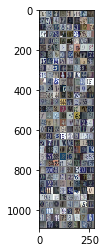

    9     8     3     8     1     1     4     7     7     1     4     7     2     8     5     5


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(16)))

### Build CNN model

In [6]:
# import torch.nn as nn
# import torch.nn.functional as F

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
        
#         # Layer 1
#         self.conv1 = nn.Conv2d(1, 16, 3) # 28x28 -> 26x26  /40x40 -> 38x38 / 60x60 -> 58x58 / 80x80 -> 78x78 / 100x100 -> 98x98
#         self.b1    = nn.BatchNorm2d(16)
#         self.pool  = nn.MaxPool2d(2, 2)  # 26x26 -> 13x13  /38x38 -> 19x19 / 58x58 -> 29x29 / 78x78 -> 39x39 / 98x98 -> 49x49
        
#         # Layer 2
#         self.conv2 = nn.Conv2d(16, 32, 3)  # 13x13 -> 11x11 /19x19 -> 17x17 / 29x29 -> 27x27 / 39x39 -> 37x37 / 49x49 -> 47x47
#         self.b2    = nn.BatchNorm2d(32)
#         #self.pool                          # 11x11 -> 5x5  /17x17 -> 8x8 / 27x27 -> 13x13 / 37x37 -> 18x18 / 47x47 -> 23x23
        
#         # Layer 3
#         self.conv3 = nn.Conv2d(32, 64, 3) # 5x5 -> 3x3  / 8x8 -> 6x6 / 13x13 -> 11x11 / 18x18 -> 16x16 / 23x23 -> 21x21
#         self.b3    = nn.BatchNorm2d(64)
#         #self.pool                          # 3x3 -> 1x1  /6x6 -> 3x3 / 11x11 -> 5x5 / 16x16 -> 8x8 / 21x21 -> 10x10
        
#         # FC Layers
#         self.fc1 = nn.Linear(64 * 1 * 1, 256)
#         self.bf1 = nn.BatchNorm1d(256)
        
#         self.fc2 = nn.Linear(256, 128)
#         self.bf2 = nn.BatchNorm1d(128)
        
#         self.fc3 = nn.Linear(128, 10)

#     def forward(self, x):
       
#         # Layer 1
#         x = self.pool(F.relu(self.b1(self.conv1(x))))
        
#         # Layer 2
#         x = self.pool(F.relu(self.b2(self.conv2(x))))
        
#         # Layer 3
#         x = self.pool(F.relu(self.b3(self.conv3(x))))
        
#         # Flatten tensors
#         x = x.view(-1, self.num_flat_features(x))
        
#         # FC Layer 1
#         x = F.relu(self.bf1(self.fc1(x)))
#         x = F.dropout(x, training=self.training)
        
#         # FC Layer 2
#         x = F.relu(self.bf2(self.fc2(x)))
#         x = F.dropout(x, training=self.training)
        
#         # FC Layer 3
#         x = self.fc3(x)
#         return x
    
    
#     def num_flat_features(self, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features

# net = Net()
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     net = nn.DataParallel(net)

# net.to(device)

# print(net)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(3, 16, 3) # 32x32 -> 30x30 / 28x28 -> 26x26  /40x40 -> 38x38 / 60x60 -> 58x58 / 80x80 -> 78x78 / 100x100 -> 98x98
        self.b1    = nn.BatchNorm2d(16)
        self.pool  = nn.MaxPool2d(2, 2)  # 30x30 -> 15x15 / 26x26 -> 13x13  /38x38 -> 19x19 / 58x58 -> 29x29 / 78x78 -> 39x39 / 98x98 -> 49x49
        
        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, 3)  # 15x15 -> 13x13 / 13x13 -> 11x11 /19x19 -> 17x17 / 29x29 -> 27x27 / 39x39 -> 37x37 / 49x49 -> 47x47
        self.b2    = nn.BatchNorm2d(32)
        #self.pool                       # 13x13 -> 6x6 / 11x11 -> 5x5  /17x17 -> 8x8 / 27x27 -> 13x13 / 37x37 -> 18x18 / 47x47 -> 23x23
        
        # Layer 3
        self.conv3 = nn.Conv2d(32, 64, 3) # 6x6 -> 4x4 / 5x5 -> 3x3  / 8x8 -> 6x6 / 13x13 -> 11x11 / 18x18 -> 16x16 / 23x23 -> 21x21
        self.b3    = nn.BatchNorm2d(64)
        #self.pool                        # 4x4 -> 2x2 / 3x3 -> 1x1  /6x6 -> 3x3 / 11x11 -> 5x5 / 16x16 -> 8x8 / 21x21 -> 10x10
        
        # FC Layers
        self.fc1 = nn.Linear(64 * 2 * 2, 256)
        self.bf1 = nn.BatchNorm1d(256)
        
        self.fc2 = nn.Linear(256, 128)
        self.bf2 = nn.BatchNorm1d(128)
        
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
       
        # Layer 1
        x = self.pool(F.relu(self.b1(self.conv1(x))))
        
        # Layer 2
        x = self.pool(F.relu(self.b2(self.conv2(x))))
        
        # Layer 3
        x = self.pool(F.relu(self.b3(self.conv3(x))))
        
        # Flatten tensors
        x = x.view(-1, self.num_flat_features(x))
        
        # FC Layer 1
        x = F.relu(self.bf1(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        
        # FC Layer 2
        x = F.relu(self.bf2(self.fc2(x)))
        x = F.dropout(x, training=self.training)
        
        # FC Layer 3
        x = self.fc3(x)
        return x
    
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    net = nn.DataParallel(net)

net.to(device)

print(net)

Let's use 4 GPUs!
DataParallel(
  (module): Net(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (b1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (b2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (b3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (bf1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (bf2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc3): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Define a loss function and optimizer

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

### Define Trainer

In [9]:
def train(epoch, dataloader):
    net.train()
    
    running_loss = 0.0
    total = 0
    correct = 0.0
    
    for i, data in enumerate(dataloader, 0):
        # get the inputs
        inputs, labels = data
        
        # For Multi-gpu processing
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        net.train(True) # Set to Train mode
        outputs = net(inputs)
        
        # Calculate Loss
        loss = criterion(outputs, labels)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Calculate Training Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()    

        # print statistics
        running_loss += loss.item()
        if i % log_interval == 0:    # print every 200 mini-batches
            print('Train Epoch : %2d [%6d, %6d] loss: %.3f TrnAcc: %.3f' %
                  (epoch, total, len(dataloader.dataset), running_loss / log_interval, correct / total))
            running_loss = 0.0

### Define Validator

In [10]:
def test():
    net.eval()
    # Calculate Validation Accuracy
    total_eval = 0
    correct_eval = 0.0
    with torch.no_grad():
        for images_eval, labels_eval in testloader:
            images_eval, labels_eval = images_eval.to(device), labels_eval.to(device)
            outputs_eval = net(images_eval)
            _, predicted_eval = torch.max(outputs_eval.data, 1)
            total_eval += labels_eval.size(0)
            correct_eval += (predicted_eval == labels_eval).sum().item() 
    val_acc = correct_eval / total_eval
    print('Test | Size : %6d  | ValAcc: %.3f\n' %
          (len(testloader.dataset), val_acc))
    return val_acc

### Train the network

In [11]:
test() # Show initial performance

best_val_acc = 0.0
best_epoch = 0

for epoch in range(10):  # loop over the dataset multiple times
    train(epoch, trainloader)
    train(epoch, extraloader)
    val_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        # Save model
        net.train()
#         torch.save(net.module.state_dict(), './results/model_190314.pth')
#         torch.save(optimizer.state_dict(), './results/optimizer_190314.pth')
        torch.save({
                    'epoch': best_epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': best_val_acc
                    }, 
                    './results/model_190314.pth')        
        
        print ("\x1b[31m BEST EPOCH UPDATED!! [%d] \x1b[0m" % (best_epoch))
print('Finished Training')

Test | Size :  26032  | ValAcc: 0.064

Train Epoch :  0 [   256,  73257] loss: 0.012 TrnAcc: 0.082
Train Epoch :  0 [ 51456,  73257] loss: 1.373 TrnAcc: 0.550
Train Epoch :  0 [   256, 531131] loss: 0.002 TrnAcc: 0.875
Train Epoch :  0 [ 51456, 531131] loss: 0.374 TrnAcc: 0.892
Train Epoch :  0 [102656, 531131] loss: 0.301 TrnAcc: 0.903
Train Epoch :  0 [153856, 531131] loss: 0.263 TrnAcc: 0.910
Train Epoch :  0 [205056, 531131] loss: 0.245 TrnAcc: 0.915
Train Epoch :  0 [256256, 531131] loss: 0.224 TrnAcc: 0.919
Train Epoch :  0 [307456, 531131] loss: 0.210 TrnAcc: 0.923
Train Epoch :  0 [358656, 531131] loss: 0.198 TrnAcc: 0.926
Train Epoch :  0 [409856, 531131] loss: 0.192 TrnAcc: 0.928
Train Epoch :  0 [461056, 531131] loss: 0.180 TrnAcc: 0.930
Train Epoch :  0 [512256, 531131] loss: 0.177 TrnAcc: 0.932
Test | Size :  26032  | ValAcc: 0.918

 BEST EPOCH UPDATED!! [0] 
Train Epoch :  1 [   256,  73257] loss: 0.002 TrnAcc: 0.867
Train Epoch :  1 [ 51456,  73257] loss: 0.395 TrnAcc: 0

Train Epoch :  9 [358656, 531131] loss: 0.096 TrnAcc: 0.973
Train Epoch :  9 [409856, 531131] loss: 0.102 TrnAcc: 0.973
Train Epoch :  9 [461056, 531131] loss: 0.093 TrnAcc: 0.973
Train Epoch :  9 [512256, 531131] loss: 0.100 TrnAcc: 0.973
Test | Size :  26032  | ValAcc: 0.951

 BEST EPOCH UPDATED!! [9] 
Finished Training


In [12]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
module.conv1.weight 	 torch.Size([16, 3, 3, 3])
module.conv1.bias 	 torch.Size([16])
module.b1.weight 	 torch.Size([16])
module.b1.bias 	 torch.Size([16])
module.b1.running_mean 	 torch.Size([16])
module.b1.running_var 	 torch.Size([16])
module.b1.num_batches_tracked 	 torch.Size([])
module.conv2.weight 	 torch.Size([32, 16, 3, 3])
module.conv2.bias 	 torch.Size([32])
module.b2.weight 	 torch.Size([32])
module.b2.bias 	 torch.Size([32])
module.b2.running_mean 	 torch.Size([32])
module.b2.running_var 	 torch.Size([32])
module.b2.num_batches_tracked 	 torch.Size([])
module.conv3.weight 	 torch.Size([64, 32, 3, 3])
module.conv3.bias 	 torch.Size([64])
module.b3.weight 	 torch.Size([64])
module.b3.bias 	 torch.Size([64])
module.b3.running_mean 	 torch.Size([64])
module.b3.running_var 	 torch.Size([64])
module.b3.num_batches_tracked 	 torch.Size([])
module.fc1.weight 	 torch.Size([256, 256])
module.fc1.bias 	 torch.Size([256])
module.bf1.weight 	 torch.Size([256])
module

Train Epoch :  4 [ 56016,  60000] loss: 0.051 TrnAcc: 0.940
Test | Size :  10000  | ValAcc: 0.987

Train Epoch :  8 [ 56016,  60000] loss: 0.059 TrnAcc: 0.940
Test | Size :  10000  | ValAcc: 0.988

### Refs
https://www.kaggle.com/sdelecourt/cnn-with-pytorch-for-mnist

https://nextjournal.com/gkoehler/pytorch-mnist